In [61]:
%matplotlib inline
import pylab
import numpy as np

In [62]:
class AdaptiveControl(object):
    def __init__(self, n_inputs, n_outputs, n_neurons, seed=None, learning_rate=1e-3):
        self.rng = np.random.RandomState(seed=seed)
        self.compute_encoders(n_inputs, n_neurons)
        self.initialize_decoders(n_neurons, n_outputs)
        self.learning_rate=learning_rate
        
    def step(self, state, error):
        # feed input over the static synapses
        current = self.compute_neuron_input(state)
        # do the neural nonlinearity
        activity = self.neuron(current)
        # apply the learned synapses        
        value = self.compute_output(activity)
        
        # update the synapses with the learning rule
        delta = np.outer(error, activity)
        self.decoder -= delta * self.learning_rate
        
        return value
    
    def compute_encoders(self, n_inputs, n_neurons):
        # generate the static synapses
        # NOTE: this algorithm could be changed, and just needs to produce a similar
        # distribution of connection weights.  Changing this distribution slightly
        # changes the class of functions the neural network will be good at learning
        max_rates = self.rng.uniform(0.5, 1, n_neurons)
        intercepts = self.rng.uniform(-1, 1, n_neurons)
        
        gain = max_rates / (1 - intercepts)
        bias = -intercepts * gain        
        
        enc = self.rng.randn(n_neurons, n_inputs)
        enc /= np.linalg.norm(enc, axis=1)[:,None]
        
        self.encoder = enc * gain[:, None]
        self.bias = bias
                
    def initialize_decoders(self, n_neurons, n_outputs):
        self.decoder = np.zeros((n_outputs, n_neurons))
        
    def compute_neuron_input(self, state):
        return np.dot(self.encoder, state) + self.bias
    
    def neuron(self, current):
        return np.maximum(current, 0)
    
    def compute_output(self, activity):
        return np.dot(self.decoder, activity)
    

Let's quickly examine what sorts of activity values the neurons give for different inputs.

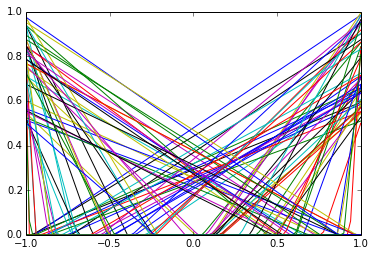

In [65]:
n_neurons = 100
ac = AdaptiveControl(n_inputs=1, n_outputs=1, n_neurons=n_neurons, seed=1)

inputs = np.linspace(-1, 1, 100)
rates = np.zeros((len(inputs), n_neurons))
for i, input in enumerate(inputs):
    current = ac.compute_neuron_input([input])
    activity = ac.neuron(current)
    rates[i, :] = activity
pylab.plot(inputs, rates);

Now let's try teaching the model to just output the identity function (i.e. the output should be the same as the input).  We train it over a sine wave.

In [84]:
n_neurons = 100
ac = AdaptiveControl(n_inputs=1, n_outputs=1, n_neurons=n_neurons, seed=1, learning_rate=1e-3)

inputs = []
outputs = []
errors = []
error = np.zeros(1)
for i in range(2000):
    input = np.sin(i*2*np.pi/1000)
    output = ac.step([input], error)
    error[:] = output - input
    inputs.append(input)
    outputs.append(output)
    errors.append(output-input)
    
    
    

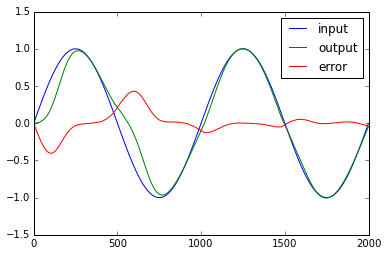

In [85]:
pylab.plot(inputs, label='input')
pylab.plot(outputs, label='output')
pylab.plot(errors, label='error')
pylab.legend(loc='best')
pylab.show()